In [1]:
import pickle
import pandas as pd
import numpy as np

import sys
sys.path.append("C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/src")  # Adjust this path as needed
from metrics import rmse_value, pearson_correlation, snr
from vis import plot_eeg

In [2]:
data_path = "C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/data/eeg_dataset.pkl"
with open(data_path, "rb") as f:
    eeg_datasets_dict = pickle.load(f)
#eeg_datasets_dict
results_emd_dataset = eeg_datasets_dict["results_emd_denoising"]
results_eemd_dataset = eeg_datasets_dict["results_eemd_denoising"]
original_eeg_dataset = eeg_datasets_dict["original_eeg"]
results_emd_threshold_dataset = eeg_datasets_dict["results_emd_threshold"]
results_eemd_threshold_dataset = eeg_datasets_dict["results_eemd_threshold"]

In [3]:
original_eeg_dataset["dataset_original"].keys()

dict_keys(['channel_names', 'original_scaled_eeg'])

In [4]:
original_eeg = original_eeg_dataset["dataset_original"]["original_scaled_eeg"]
channel_names = original_eeg_dataset["dataset_original"]["channel_names"]
noisy_eeg = original_eeg_dataset["dataset_noisy"]["noisy_scaled_eeg"]

# Evaluation of burst noise denoising

In [5]:
#Calculating Metrics for EMD

metrics_results = pd.DataFrame(columns=["IMFs removed", 'rmse', 'pearson_correlation', 'snr'])

for i, dataset_results in enumerate(results_emd_dataset):
    parameter_sets = dataset_results['parameter_sets']
    denoised_signals = dataset_results['denoised_signals']
    print(f"Original signal shape: {len(parameter_sets)}")
    print(f"Parameter sets shape: {len(denoised_signals)}")

    rmse_ = np.mean([rmse_value(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    pearson = np.mean([pearson_correlation(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    snr_ = np.mean([snr(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    print(f"Parameters: {parameter_sets[0]}, RMSE: {rmse_}, Pearson: {pearson}")

    metrics_results.loc[len(metrics_results)] = [parameter_sets[0], rmse_, pearson, snr_]
    print(f"Metrics results shape: {len(metrics_results)}")

Original signal shape: 64
Parameter sets shape: 64
Parameters: 1, RMSE: 1.1609808728781141, Pearson: 0.72737884909704
Metrics results shape: 1
Original signal shape: 64
Parameter sets shape: 64
Parameters: 2, RMSE: 1.1958546897185118, Pearson: 0.6859391763157829
Metrics results shape: 2


In [6]:
# Results of EMD denoising
metrics_results

,IMFs removed,rmse,pearson_correlation,snr
0,1.0,1.160981,0.727379,6.368911
1,2.0,1.195855,0.685939,3.040331


In [7]:
#Calculating Metrics for EEMD
results_eemd = results_eemd_dataset[0]
num_signals = len(results_eemd)
num_params = len(results_eemd[0]['parameter_sets'])
print(num_signals, num_params)

metrics_results_eemd = pd.DataFrame(columns=["Noise", 'rmse', 'pearson_correlation', 'snr'])

for param_idx in range(num_params):
    param = results_eemd[0]['parameter_sets'][param_idx]  # Assume all signals have the same param order

    rmse_list = []
    pearson_list = []
    snr_list = []

    for sig_idx in range(num_signals):
        original = original_eeg[sig_idx]
        denoised = results_eemd[sig_idx]['denoised_signals'][param_idx]

        rmse_list.append(rmse_value(original, denoised))
        pearson_list.append(pearson_correlation(original, denoised))
        snr_list.append(snr(original, denoised))

    rmse_mean = np.mean(rmse_list)
    pearson_mean = np.mean(pearson_list)
    snr_mean = np.mean(snr_list)

    metrics_results_eemd.loc[len(metrics_results_eemd)] = [param, rmse_mean, pearson_mean, snr_mean]


64 5


In [8]:
metrics_results_eemd.head()

,Noise,rmse,pearson_correlation,snr
0,0.40,0.182456,0.981778,32.498021
1,0.30,0.188458,0.980620,30.401760
2,0.20,0.202095,0.977800,26.617360
3,0.10,0.228647,0.971664,20.789530
4,0.05,0.247000,0.966949,17.740206


In [9]:
#Calculating Metrics for EEMD thresholding

metrics_results_eemd_thresh = pd.DataFrame(columns=["Signal", "Noise", "Method", "rmse", "pearson_correlation", "snr"])

for sig_idx, signal_dict in enumerate(results_eemd_threshold_dataset):
    for param, method_dict in signal_dict.items():
        for method, denoised in method_dict.items():
            original = original_eeg[sig_idx]
            rmse_val = rmse_value(original, denoised)
            pearson_val = pearson_correlation(original, denoised)
            snr_val = snr(original, denoised)
            metrics_results_eemd_thresh.loc[len(metrics_results_eemd_thresh)] = [
                sig_idx, param, method, rmse_val, pearson_val, snr_val
            ]

In [10]:
metrics_results_eemd_thresh.sort_values(by="rmse", ascending=True).head(10)

,Signal,Noise,Method,rmse,pearson_correlation,snr
283,18,0.05,hard,0.014920,0.999890,4492.058648
238,15,0.05,hard,0.015214,0.999885,4321.052138
793,52,0.05,hard,0.015913,0.999876,3949.543043
493,32,0.05,hard,0.016144,0.999875,3836.972582
508,33,0.05,hard,0.016636,0.999864,3614.149418
178,11,0.05,hard,0.016744,0.999863,3567.785105
328,21,0.05,hard,0.016865,0.999858,3516.947407
373,24,0.05,hard,0.017082,0.999856,3426.702058
778,51,0.05,hard,0.017208,0.999853,3377.497974
568,37,0.05,hard,0.017435,0.999848,3291.272203


In [11]:
# Calculating metrics for EMD Thresholding

metrics_results_emd_thresh = pd.DataFrame(columns=["Signal", "Method", "rmse", "pearson_correlation", "snr"])

for sig_idx, signal_dict in enumerate(results_emd_threshold_dataset):
    for idx, method in enumerate(signal_dict.items()):
        original = original_eeg[sig_idx]
        denoised = method[1]
        rmse_val = rmse_value(original, denoised)
        pearson_val = pearson_correlation(original, denoised)
        snr_val = snr(original, denoised)
        metrics_results_emd_thresh.loc[len(metrics_results_emd_thresh)] = [
            sig_idx,method[0], rmse_val, pearson_val, snr_val
        ]
        

In [12]:
metrics_results_emd_thresh.sort_values(by="rmse", ascending=True).head(10)

,Signal,Method,rmse,pearson_correlation,snr
1,0,hard,0.013136,0.999914,5796.974650
55,18,hard,0.013551,0.999908,5446.121716
73,24,hard,0.014117,0.999900,5018.507765
79,26,hard,0.014148,0.999900,4996.767018
46,15,hard,0.014249,0.999899,4926.343167
97,32,hard,0.014290,0.999898,4897.462474
157,52,hard,0.014353,0.999897,4854.865420
52,17,hard,0.014407,0.999896,4819.751637
28,9,hard,0.014611,0.999893,4684.872187
49,16,hard,0.014806,0.999890,4563.261355


## Plotting some of the results

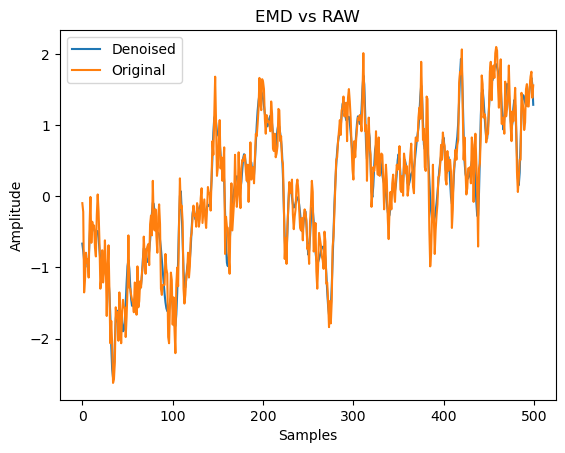

array([-0.66615573, -0.76824455, -0.90195668, ...,  4.85078574,
        5.12731686,  5.40562104])

In [13]:
import matplotlib.pyplot as plt
emd_plotted = results_emd_dataset[0]['denoised_signals'][0]
plt.plot(emd_plotted[:500], label = "Denoised")
plt.plot(original_eeg[0][:500], label="Original")
plt.legend()
plt.title("EMD vs RAW")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

emd_plotted

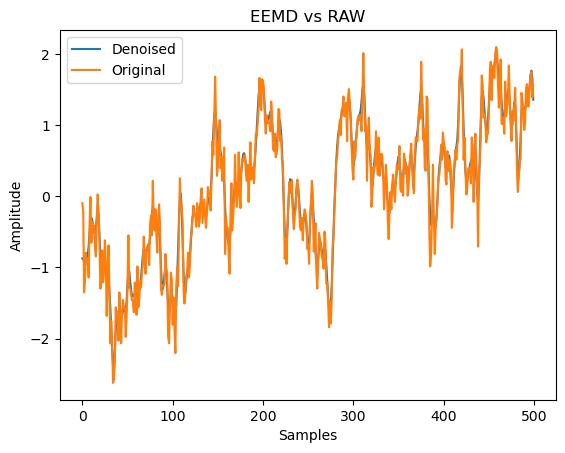

In [14]:
denoised_plotted = results_eemd[0]['denoised_signals'][0]

plt.plot(denoised_plotted[:500], label="Denoised")
plt.plot(original_eeg[0][:500], label="Original")
plt.legend()
plt.title("EEMD vs RAW")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


# Power Spectral Decomposition

In [15]:
results_eemd[0]

{'parameter_sets': [0.4, 0.3, 0.2, 0.1, 0.05],
 'denoised_signals': [array([-0.87396199, -0.87936412, -0.92668372, ..., -0.03126437,
         -0.03621664, -0.03102377]),
  array([-0.83843127, -0.82248865, -0.90755104, ..., -0.02673097,
         -0.01845225, -0.01811718]),
  array([-0.86261805, -0.89202948, -0.95631726, ..., -0.03461904,
         -0.02552954, -0.01582806]),
  array([-0.89341691, -0.94760727, -1.0155599 , ..., -0.01821653,
         -0.0192623 , -0.01885247]),
  array([-0.81618832, -0.90285128, -0.97009738, ..., -0.0240128 ,
         -0.02148763, -0.02023846])]}

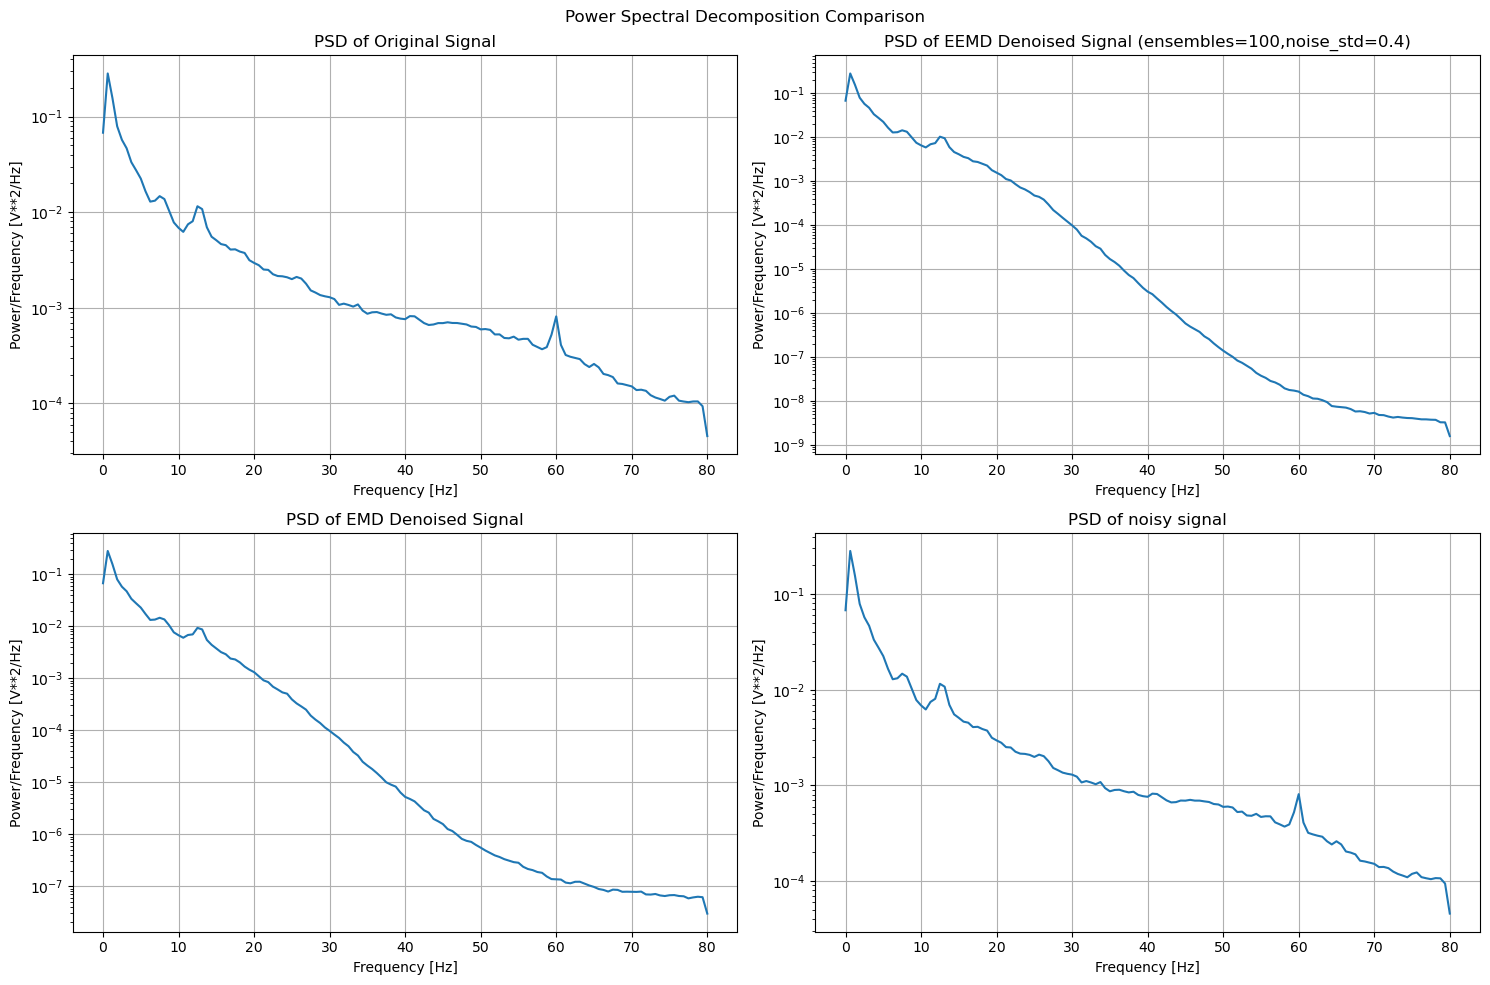

In [16]:
from scipy.signal import welch
psd_og_signal = original_eeg[0]
psd_eemd_signal = results_eemd[0]['denoised_signals'][0]
psd_noisy_signal = noisy_eeg[0]
psd_emd_signal = results_emd_dataset[0]['denoised_signals'][0]
plt.figure(figsize=(15, 10))
f1, Pxx1 = welch(psd_og_signal, fs=160)
f2, Pxx2 = welch(psd_eemd_signal, fs=160)
f3, Pxx3 = welch(psd_emd_signal, fs=160)
f4, Pxx4 = welch(psd_noisy_signal, fs=160)
plt.subplot(2,2,1)
plt.suptitle("Power Spectral Decomposition Comparison")
plt.semilogy(f1, Pxx1)
plt.title(f'PSD of Original Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,2)
plt.semilogy(f2, Pxx2)
plt.title(f'PSD of EEMD Denoised Signal (ensembles=100,noise_std=0.4)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,3)
plt.semilogy(f3, Pxx3)
plt.title(f'PSD of EMD Denoised Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,4)
plt.semilogy(f4, Pxx4)
plt.title(f'PSD of noisy signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.tight_layout()

plt.show()